In [43]:
import gurobipy as gp
from gurobipy import GRB
import json
import geopy
from geopy.distance import distance

---
# Input Data
---

In [44]:
with open('f1-locations-2022.json') as file_handle:
    data = json.load(file_handle) # 22 cities in 2022, 23 in 2023

In [45]:
dist = []
zeros = [0] * (len(data)+1)
dist.append(zeros)
for i in range(len(data)):
    newRow = [0]
    for j in range(len(data)):
        coord_i = (data[i]['lat'], data[i]['lon'])
        coord_j = (data[j]['lat'], data[j]['lon'])
        distance = geopy.distance.distance(coord_i, coord_j).km
        newRow.append(distance)
    dist.append(newRow)

In [46]:
# import csv
# file_path = 'nested_list.csv'
# with open(file_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(distRounded)

In [47]:
# from copy import copy
# distRounded = copy(dist)
# for i in range(23):
#     for j in range(23):
#         if i > j:
#             distRounded[i][j] = 0
#         else:
#             distRounded[i][j] = round(distRounded[i][j])



In [48]:
# import csv
# file_path = 'nested_list.csv'
# with open(file_path, 'w', newline='') as csvfile:
#     writer = csv.writer(csvfile)
#     writer.writerows(distRounded)

In [49]:
n = len(dist) # number of nodes(23), including artificial one
N = range(n) # 0...22
for row in dist:
    print(row)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0.0, 1259.5700854390595, 12105.116389313182, 4023.0145511141486, 12205.12297547132, 4718.513976100133, 4337.807834531282, 1591.4450573882093, 10278.808460759305, 5164.104082982914, 3914.3710184981182, 4456.983322341206, 3630.9795503254013, 4645.132821450051, 4809.828595807177, 4247.127567980452, 6327.619674487589, 8068.817235207537, 12928.36717553616, 14007.830906043837, 11812.74552972678, 446.6875930783488]
[0, 1259.5700854390595, 0.0, 12814.985660973129, 3558.6513335738923, 11623.489783742016, 4089.9847995850396, 3810.5362726240974, 2312.3626045893907, 9946.286855754606, 4816.396763326816, 3583.155109793424, 3901.3625751607956, 3384.4608405879867, 4307.060328852237, 4514.615956879085, 3796.8008238629855, 7358.344703838267, 9308.479213637303, 12650.836673573129, 13592.17062068135, 10553.66065482694, 1618.0311331048524]
[0, 12105.116389313182, 12814.985660973129, 0.0, 16082.889170591929, 15596.86836899574, 16823.

In [50]:
def tour(edges):
    unvisited = list(range(n))
    thiscycle = []
    neighbors = unvisited
    while unvisited: # Solange erfüllt, wie Elemente in unvisited sind
        current = neighbors[0]
        thiscycle.append(current)
        unvisited.remove(current)
        neighbors = [j for i, j in edges.select(current, '*')
                        if j in unvisited]
    return thiscycle

---
# Modeling
---

In [51]:
m = gp.Model()

In [52]:
x = {}
for i in N:
    for j in N:
        if i != j:
            x[i,j] = m.addVar(vtype = GRB.BINARY, name= "x_"+str(i)+"_"+str(j))
# precedence
u = m.addVars(range(1,n), ub = n, vtype = GRB.INTEGER, name='u') #skips artificial node

In [53]:
m.setObjective(gp.quicksum(gp.quicksum(dist[i][j]*x[i,j] for j in N if i != j)for i in N))

In [54]:
# 1 incoming edge
for j in N:
    m.addConstr(gp.quicksum(x[i,j] for i in N if i != j) == 1, "edgeIn" + str(j))
# 1 outgoing edge
for i in N:
    m.addConstr(gp.quicksum(x[i,j] for j in N if i != j) == 1, "edgeOut" + str(i))
# subtour elimination
for i in range(1,n):
    for j in range(1,n):
        if i!=j:
            m.addConstr(u[i] - u[j] + (n-1) * x[i,j] <= n - 2)
# only one solution corresponding to a given feasible tour
for i in range(1,n):
    m.addConstr(1 <= u[i])
    m.addConstr(u[i] <= n-1)
#u = 1... 21?

----
### additional Constraints
----

In [55]:
M = 100  # Large constant

### Environmental ###
europe = [4,5,6,7,11,12,13,14,15,16]
# for race in europe:
#     m.addConstr(u[race] <= 16, name = "europeNotColdUpper"+str(race))
#     m.addConstr(u[race] >= 4 , name = "europeNotColdLower"+str(race))
for race in europe:
    m.addLConstr(u[race] <= 16, name = "europeNotColdUpper"+str(race))
    m.addLConstr(u[race] >= 4 , name = "europeNotColdLower"+str(race))

arabianPeninsula = [1, 2, 22]  # Bahrain, Saudi Arabia, UAE
a = {}
for race in arabianPeninsula:
    a[race] = m.addVar(vtype=gp.GRB.BINARY, name=f"a_{race}")
for race in arabianPeninsula:
    m.addLConstr(u[race] <= 4 + M * a[race], name="arabiaNotHot_upper"+str(race))
    m.addLConstr(u[race] >= 17 - M * (1 - a[race]), name="arabiaNotHot_lower"+str(race))

m.addLConstr(u[9] >= 8, name = "canadaNoSnow_lower")
m.addLConstr(u[9] <= 16, name = "canadaNoSnow_upper")

#die Constraint hauts komplett weg
m.addLConstr(u[5] <= 7, name = "miamiHurricaneSeason") #June 1st through November 30th

#die nächsten könnten schärfer formuliert werden
j = m.addVar(vtype = gp.GRB.BINARY, name = "j")
m.addLConstr(u[18] <= 4 + M * j, name="japanNoRain_lower") #ende april bis 7 okt -> kleiner gleich 4, größer gleich 17
m.addLConstr(u[18] >= 17 - M * (1 - j), name="japanNoRain_upper")

#USA hot summer
USA = [5,19]
us = {}
for race in USA:
    us[race] = m.addVar(vtype=gp.GRB.BINARY, name=f"us_{race}")
for race in USA:
    m.addLConstr(u[race] <= 7 + M*us[race])
    m.addLConstr(u[race] >= 16 - M*(1-us[race]))

### Contractual ###
m.addLConstr(u[1] == 1, name = "bahrainFirst")
m.addLConstr(u[22] == 22, name = "abuDhabiLast")
m.addLConstr(u[7] == 7, name = "monacoEndOfMai")

#Modelling will be done math like in Gurobi -> Big M Constraints

<gurobi.Constr *Awaiting Model Update*>

---
# Results
---

In [56]:
#current schedule:
length = []
for i in range(len(dist)-1):
    length.append(dist[i][i+1])
print(sum(length))

116223.34502775173


116223,34502775173

In [57]:
#time_limit = 60
time_limit = 3600*4  # 1 hour in seconds
m.Params.TimeLimit = time_limit
m.optimize()
if m.status == gp.GRB.TIME_LIMIT:
    print("Time limit reached. Solution may be suboptimal.")

Set parameter TimeLimit to value 14400
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 590 rows, 534 columns and 2492 nonzeros
Model fingerprint: 0x9cdb35e5
Variable types: 0 continuous, 534 integer (512 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [1e+02, 2e+04]
  Bounds range     [1e+00, 2e+01]
  RHS range        [1e+00, 8e+01]
Presolve removed 167 rows and 94 columns
Presolve time: 0.01s
Presolved: 423 rows, 440 columns, 1956 nonzeros
Variable types: 0 continuous, 440 integer (421 binary)

Root relaxation: objective 4.709149e+04, 60 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 47091.4858    0   43          - 47091.4858      -     -    0s
     0     0 48672.3932    0   45

In [58]:
vals = m.getAttr('x', x) # Gibt Tupledict zurück jedoch sind die Values nun das Attribut X des Keys (i,j).
selected = gp.tuplelist((i, j) for i, j in vals.keys() if vals[i, j] > 0.5)
# selected beinhaltet alle Kanten, die in der Lösung vorhanden sind
tour = tour(selected)
assert len(tour) == n
print('')
print('Tour: %s' % str(tour[1:]))# skipped den künstlichen Knoten (0)
print('Cost: %g' % m.objVal)
print('')
remaining_gap = m.MIPGap
# Print the remaining gap
print("Remaining Gap: ", remaining_gap)

print("Number of variables:", m.NumVars)
print("Number of constraints:", m.NumConstrs)


Tour: [1, 2, 21, 5, 6, 12, 7, 16, 4, 11, 13, 14, 15, 10, 9, 19, 20, 3, 17, 18, 8, 22]
Cost: 72176.2

Remaining Gap:  0.0864448844067348
Number of variables: 534
Number of constraints: 590


Optimal tour: [3, 17, 18, 8, 22, 1, 2, 13, 11, 4, 16, 7, 12, 6, 14, 15, 10, 9, 19, 20, 5, 21]

Optimal cost: 46 411 km


Berechnung nach 4h abgebrochen
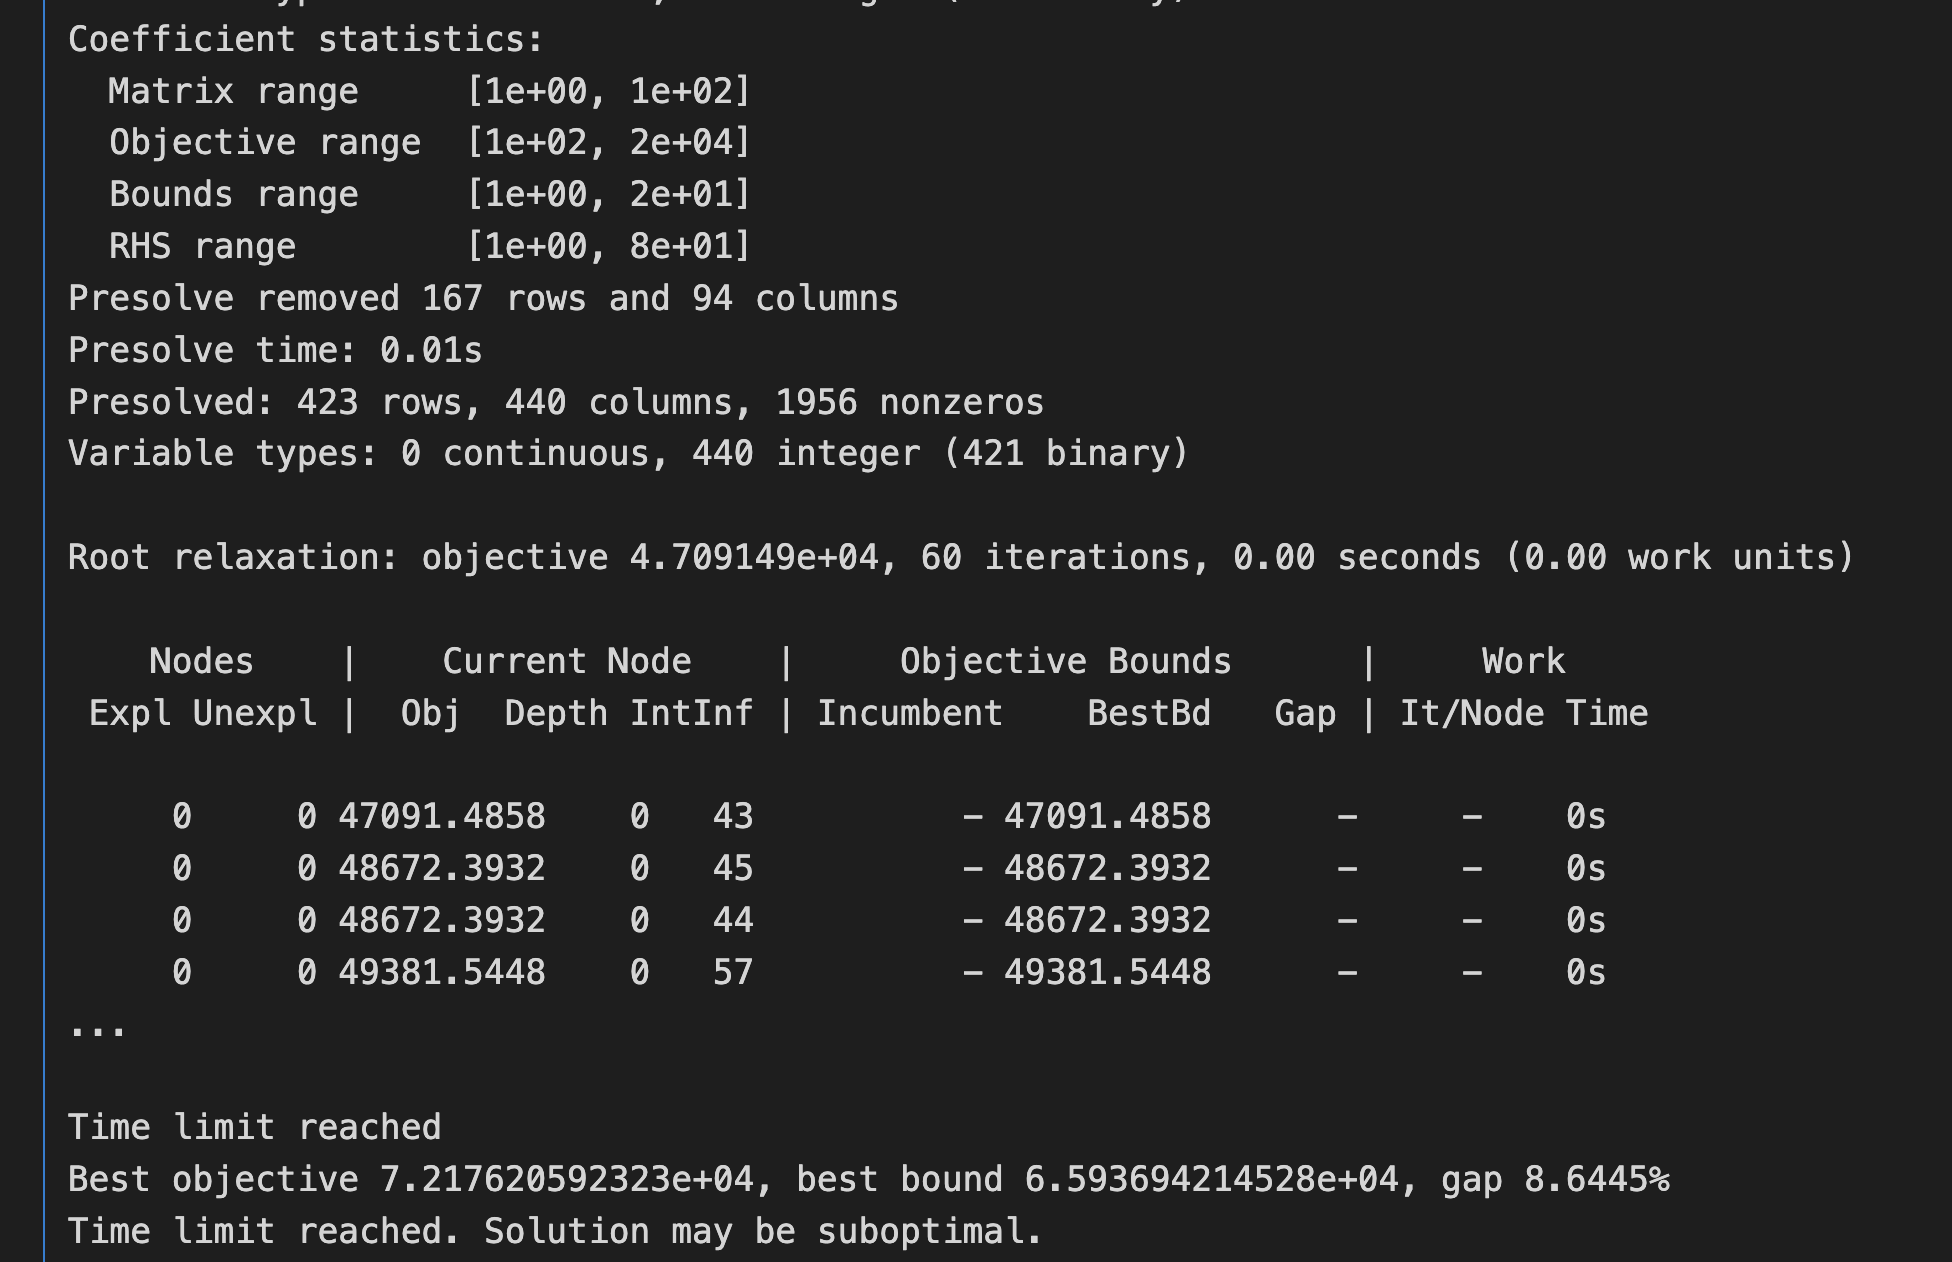

In [59]:
import pandas as pd
import plotly.graph_objects as go
import kaleido

In [65]:
df = pd.DataFrame(data)
#order = list(tour[1:])
order = list(range(22))
#order = [x - 1 for x in order]
df_sorted = df.iloc[order]

# Creating a scatter plot for cities
cities = go.Scattergeo(
    locationmode='ISO-3',
    lon=df_sorted['lon'],
    lat=df_sorted['lat'],
    mode='markers',
    text=df_sorted['name'],
    marker=dict(
        color='red',
        size=4,  # Adjust the size of red points
        line=dict(color='rgb(0,0,0)', width=1),
        symbol='circle'
    )
)

# Connecting locations in order
line_coordinates = list(zip(df_sorted['lon'], df_sorted['lat']))
line_trace = go.Scattergeo(
    locationmode='ISO-3',
    lon=[coord[0] for coord in line_coordinates],
    lat=[coord[1] for coord in line_coordinates],
    mode='lines',
    line=dict(width=1, color='blue'),
    hoverinfo='none'
)

# Creating the layout
layout = go.Layout(
    title='F1 Locations',
    showlegend=False,
    geo=dict(
        showland=True,
        showcountries=True,
        countrywidth=0.5,
        landcolor='rgb(243, 243, 243)',
        countrycolor='rgb(204, 204, 204)'
    )
)

# Creating the figure
fig = go.Figure(data=[cities, line_trace], layout=layout)
fig.show()
#fig.write_image("Original_schedule.pdf")

In [61]:

def formCoordinates(tour, distances):
    summand = []
    for i in range(len(tour)-1):
        summand.append(dist[tour[i]][tour[i+1]])
    cumSum = []
    total = 0
    for num in summand:
        total += num
        cumSum.append(total)
    cumSumCords = []
    for i, value in enumerate(cumSum):
        cumSumCords.append((i, value))
    return cumSumCords

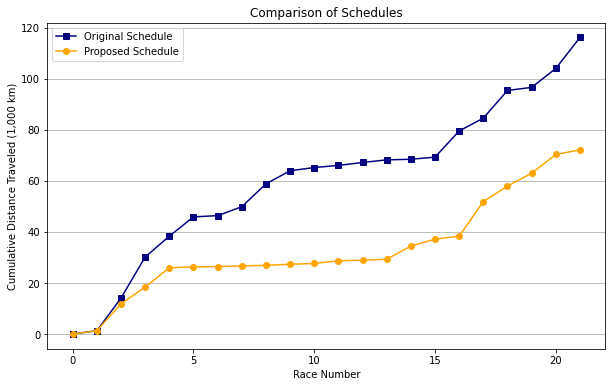

In [64]:
import matplotlib.pyplot as plt

def plot_coordinates(original_coordinates, proposed_coordinates):
    x_values_original = [coord[0] for coord in original_coordinates]
    y_values_original = [coord[1] / 1000 for coord in original_coordinates]

    x_values_proposed = [coord[0] for coord in proposed_coordinates]
    y_values_proposed = [coord[1] / 1000 for coord in proposed_coordinates]

    plt.plot(x_values_original, y_values_original, color='navy', marker='s', linestyle='-', label='Original Schedule')
    plt.plot(x_values_proposed, y_values_proposed, color ='orange', marker='o', linestyle='-', label='Proposed Schedule')
    plt.xlabel('Race Number')
    plt.ylabel('Cumulative Distance Traveled (1,000 km)')
    plt.title('Comparison of Schedules')
    plt.grid(axis='y')  # Remove vertical grid lines
    plt.legend()

    # Increase figure size for better quality
    fig = plt.gcf()
    fig.set_size_inches(10, 6)

    #plt.show()

# Example usage
plot_coordinates(formCoordinates(list(range(23)), dist), formCoordinates(tour, dist))

plt.show()
#plt.savefig("Comparison_of_Schedules.pdf")


---
# Store
---

In [63]:
# m.write("model.lp")
# m.write("solution.sol")